In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
def min_circular_shift(seq):
    min_shift = seq
    for i in range(1, len(seq)):
        shifted_seq = seq[i:] + seq[:i]
        if shifted_seq < min_shift:
            min_shift = shifted_seq
    return min_shift

In [3]:
def extract_chain_code_features(image):

    directions = [(0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1)]
    ret, bin_img = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    height, width = bin_img.shape

    # Find the first white pixel
    for x in range(height):
        for y in range(width):
            if bin_img[x][y] == 255:
                start_pos = (x, y)
                break
        else:
            continue
        break
    else:
        return []

    current_pos = start_pos
    check_dir = 0
    chain_code = []

    while True:
        for i in range(8):
            dir_index = (check_dir + i) % 8
            dx, dy = directions[dir_index]
            next_pos = (current_pos[0] + dx, current_pos[1] + dy)
            if 0 <= next_pos[0] < height and 0 <= next_pos[1] < width and bin_img[next_pos] == 255:
                if directions[dir_index] == (1, 0):
                    code = 0
                elif directions[dir_index] == (1, 1):
                    code = 1
                elif directions[dir_index] == (0, 1):
                    code = 2
                elif directions[dir_index] == (-1, 1):
                    code = 3
                elif directions[dir_index] == (-1, 0):
                    code = 4
                elif directions[dir_index] == (-1, -1):
                    code = 5
                elif directions[dir_index] == (0, -1):
                    code = 6
                elif directions[dir_index] == (1, -1):
                    code = 7
                chain_code.append(code)
                check_dir = (dir_index + 5) % 8
                current_pos = next_pos
                break
        else:
            break
        if current_pos == start_pos:
            break

    if not chain_code:
        return []

    min_shift = min_circular_shift(chain_code)
    return min_shift


In [4]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
extracted_features = []
for image in X:
    chain_code = extract_chain_code_features(image)
    extracted_features.append(chain_code)

In [6]:
max_length = max(map(len, extracted_features))
final_features = []
for chain in extracted_features:
    chain_code = chain + [0] * (max_length - len(chain))
    final_features.append(chain_code)

In [7]:
final_features = np.array(final_features)
X_train, X_test, y_train, y_test = train_test_split(final_features, Y, test_size=0.3, random_state=1234)

In [8]:
model = RandomForestClassifier(random_state=1234)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

In [9]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:0.2f} %")

Accuracy: 90.90 %


In [10]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,y_pred,labels=list(np.arange(0,10)))

Text(0.5, 58.7222222222222, 'Predicted label')

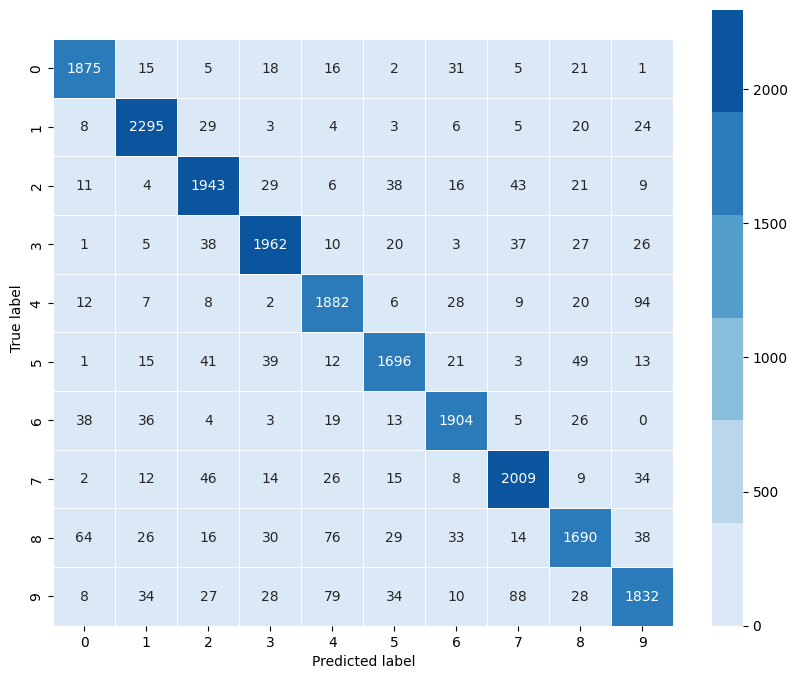

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion, annot=True,ax=ax,fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"));
plt.ylim([ 10,-0.5,]);
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [12]:
from sklearn.metrics import classification_report
target_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7", "Class 8", "Class 9"]
print(classification_report(y_test,y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.94      1989
     Class 1       0.94      0.96      0.95      2397
     Class 2       0.90      0.92      0.91      2120
     Class 3       0.92      0.92      0.92      2129
     Class 4       0.88      0.91      0.90      2068
     Class 5       0.91      0.90      0.91      1890
     Class 6       0.92      0.93      0.93      2048
     Class 7       0.91      0.92      0.91      2175
     Class 8       0.88      0.84      0.86      2016
     Class 9       0.88      0.85      0.86      2168

    accuracy                           0.91     21000
   macro avg       0.91      0.91      0.91     21000
weighted avg       0.91      0.91      0.91     21000

